In [1]:
import numpy as np
import pandas as pd
import torch
from utils.ae_script import (prepare_data, 
                             create_dataset, 
                             training_loop, 
                             generate_patient_embeddings, 
                             plot_umap_by_targets, 
                             downstream_performance,
                             interpret_model)

from utils.autoencoder_model import (MultimodalCrossAttentionAutoencoder,
                                     Autoencoder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ---------------------------------------------
# 1) LOAD & PREPROCESS DATA
# ---------------------------------------------

threshold = 15  # Set the threshold for filtering mutations
df = pd.read_csv(f"./data/msk_2024_fe_{threshold}.csv")

# locate the columns index for OS_MONTHS
os_months_index = df.columns.get_loc("OS_MONTHS")

gene_mutations = df.iloc[:, :os_months_index]  # Exclude the first column (ID) and OS_MONTHS
data_labels = df.iloc[:, os_months_index:]  # Include only the OS_MONTHS column as labels

2025-03-25 04:22:31.629149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742890951.647012   90001 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742890951.652364   90001 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 04:22:31.673042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 'highest_stage_recorded', 'CNS_BRAIN', 'LIVER', 'LUNG', 'Regional', 'Distant', 'CANCER_TYPE_BREAST', 'CANCER_TYPE_COLON', 'CANCER_TYPE_LUNG', 'CANCER_TYPE_PANCREAS', 'CANCER_TYPE_PROSTATE'
cd_bin = ['highest_stage_recorded', 'CNS_BRAIN', 'LIVER', 'LUNG', 'Regional', 'Distant', 'CANCER_TYPE_BREAST', 'CANCER_TYPE_COLON', 'CANCER_TYPE_LUNG', 'CANCER_TYPE_PANCREAS', 'CANCER_TYPE_PROSTATE']
cd_num = ['CURRENT_AGE_DEID', 'TMB_NONSYNONYMOUS', 'FRACTION_GENOME_ALTERED']
GMP, CD_BINARY, CD_NUMERIC, patient_ids, all_columns, fulldata_set = prepare_data(gene_mutations, data_labels, cd_bin=cd_bin, cd_num=cd_num, device=device)
print(f"Gene Mutation Profile: {GMP.shape}")
print(f"CD Binary: {CD_BINARY.shape}")
print(f"CD Numeric: {CD_NUMERIC.shape}")
print(f"Overall Features: {GMP.shape[1] + CD_BINARY.shape[1] + CD_NUMERIC.shape[1]}")
print(f"Full Data: {fulldata_set.shape}")

Gene Mutation Profile: (22284, 966)
CD Binary: (22284, 11)
CD Numeric: (22284, 3)
Overall Features: 980
Full Data: torch.Size([22284, 980])


In [3]:
num_positives = np.sum(GMP, axis=0)  # Count the number of positive mutations for each gene
num_negatives = GMP.shape[0] - num_positives  # Count the number of negative mutations for each gene
pos_weight = num_negatives / (num_positives + 1e-6)  # Avoid division by zero
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

In [4]:
# parameters
batch_size = 4096
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_loader, val_loader = create_dataset(
    GMP, CD_BINARY, CD_NUMERIC, 
    batch_size=batch_size, 
    train_split=0.85
)

In [6]:
ae_type = "mcaae" # Choose between "msaae" "mcaae" or "gmp"
training_method = 'normal'  # Loss function for autoencoder (can be 'normal', 'masked', or 'denoising')
backbone = "self_attn" # 'mlp', 'residual', 'attn', 'attn_v2', 'self_attn'

latent_dim = 256
hidden_dim = 256
num_layers = 2  # Number of layers for the backbone (if applicable)
dropout = 0.3  # Dropout rate for the backbone (if applicable)
num_heads = 4  # Number of attention heads for the backbone (if applicable)

ae_save_path = None
patient_rep_save_path = None
ae_losses_plot_path = None
fig_save_path = None
test_results = None
model_save_path = None

if ae_type == "msaae":
    input_dim = GMP.shape[1] + CD_BINARY.shape[1] + CD_NUMERIC.shape[1]
elif ae_type == "gmp":
    input_dim = GMP.shape[1]

if ae_type == "mcaae":
    model = MultimodalCrossAttentionAutoencoder(
        input_dim_gmp=GMP.shape[1], 
        input_dim_cd=CD_BINARY.shape[1] + CD_NUMERIC.shape[1],
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        gmp_num_layers=2,
        cd_num_layers=1,
        dropout=dropout,
        cross_attn_mode="shared",    # "stacked" or "shared"
        cross_attn_layers=2,
        cd_encoder_mode="attention",   # "mlp" or "attention"
        gmp_use_pos=True,
        gmp_tokens=1
    ).to(device)
    
elif ae_type == "msaae" or ae_type == "gmp":
    model = Autoencoder(
        input_dim=input_dim, 
        latent_dim=latent_dim, 
        backbone=backbone,
        hidden_dim=hidden_dim,
        dropout=dropout,
        num_heads=num_heads,
        num_layers=num_layers,
        use_pos=True,
        num_tokens=1
    ).to(device)
else:
    raise ValueError("Invalid model type. Choose 'multimodal' or 'autoencoder'.")

Training on device: cpu
Model Type: MultimodalCrossAttentionAutoencoder
AE Type: mcaae, Training Method: normal, Learning Rate : 0.0005, L2 Lambda: 0.0001, Mask Ratio: 0.3, Noise Level: 0.1, Noise Rate: 0.1
Best model updated at epoch 1 with val loss: 3.2115
Best model updated at epoch 2 with val loss: 2.8046
Best model updated at epoch 3 with val loss: 2.5311
Best model updated at epoch 4 with val loss: 2.3160
Best model updated at epoch 5 with val loss: 2.1627
Best model updated at epoch 6 with val loss: 2.0352
Best model updated at epoch 7 with val loss: 1.9188
Best model updated at epoch 8 with val loss: 1.8031
Best model updated at epoch 9 with val loss: 1.7081
Epoch 10/70, Train Loss: 1.7298, Val Loss: 1.6267
Best model updated at epoch 10 with val loss: 1.6267
Best model updated at epoch 11 with val loss: 1.5548
Best model updated at epoch 12 with val loss: 1.4946
Best model updated at epoch 13 with val loss: 1.4435
Best model updated at epoch 14 with val loss: 1.3956
Best model

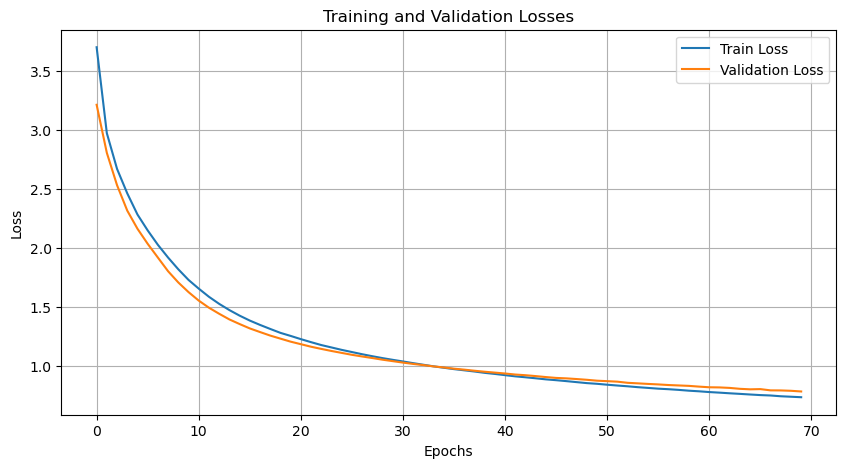

In [7]:
num_epochs = 70
# 1e-2, 5e-3, 1e-3, 5e-4, 1e-4
learning_rate = 5e-4
alpha = 0.4
l2_lambda = 1e-4
mask_ratio = 0.3  # Ratio of input features to mask (for masked autoencoder)
noise_std = 0.1  # Standard deviation of Gaussian noise (for denoising autoencoder)
noise_rate = 0.1 # Rate of noise (for denoising autoencoder)
pos_weight = pos_weight.to(device)  # Move pos_weight to the same device as the model

train_losses, val_losses, best_model = training_loop(
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,
        learning_rate = learning_rate,
        pos_weight= pos_weight,
        device= device,
        training_method = training_method,
        ae_type = ae_type,
        l2_lambda = l2_lambda,
        mask_ratio = mask_ratio,
        noise_std = noise_std,
        noise_rate = noise_rate,
        ae_save_path = ae_save_path,
        ae_losses_plot_path = ae_losses_plot_path
)

latent_rep, latent_df = generate_patient_embeddings(
    model = model,
    gmp = GMP,
    cd_binary = CD_BINARY,
    cd_numeric = CD_NUMERIC,
    best_model = best_model,
    ae_type = ae_type,
    device = device,
    latent_dim = latent_dim,
    patient_ids = patient_ids,
    save_path = patient_rep_save_path
)



Input dimension for downstream task: 256
Training on 15598 samples, validating on 3343 samples, testing on 3343 samples.
Using model: MLP with input dimension: 256
Starting training for 100 epochs...
New best model found at epoch 1 with validation loss: 7.5004 and C-Index: 0.5297
New best model found at epoch 2 with validation loss: 7.4841 and C-Index: 0.6231
New best model found at epoch 3 with validation loss: 7.4663 and C-Index: 0.6706
New best model found at epoch 4 with validation loss: 7.4474 and C-Index: 0.6918
New best model found at epoch 5 with validation loss: 7.4282 and C-Index: 0.7027
New best model found at epoch 6 with validation loss: 7.4090 and C-Index: 0.7087
New best model found at epoch 7 with validation loss: 7.3901 and C-Index: 0.7128
New best model found at epoch 8 with validation loss: 7.3722 and C-Index: 0.7156
New best model found at epoch 9 with validation loss: 7.3551 and C-Index: 0.7175
Epoch 10/100, Train Loss: 8.8326, Val Loss: 7.3391, C-Index: 0.7191
New

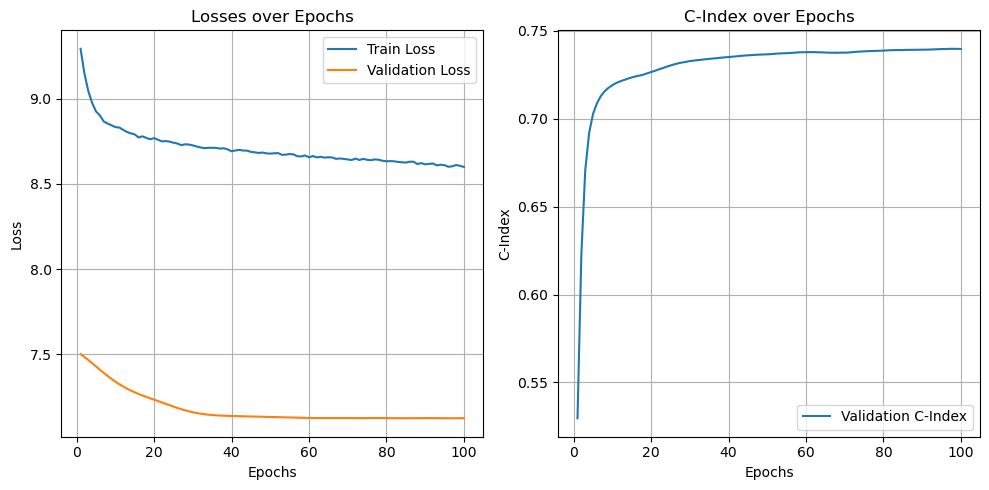

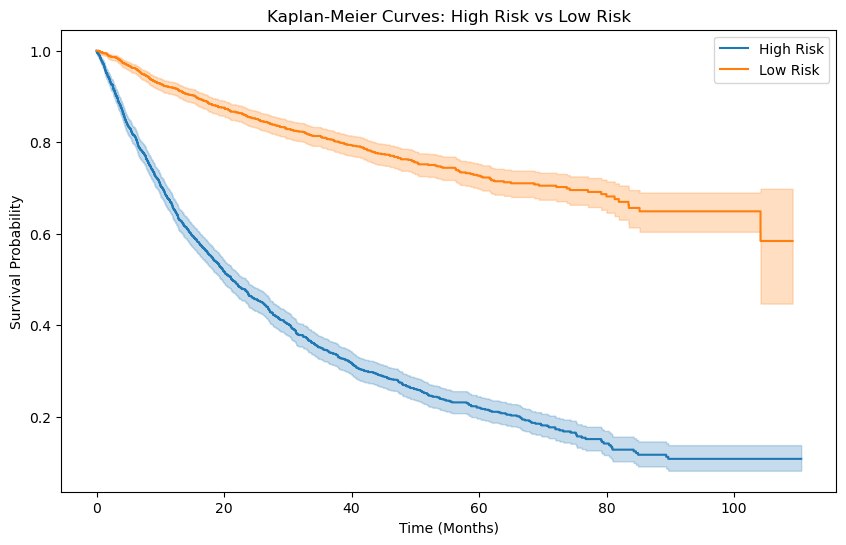

Log-rank test p-value: 2.6255111195011446e-182
Test Loss: 7.1597, Test c-index: 0.7407


In [8]:
y_os = data_labels['OS_MONTHS']
y_status = data_labels['OS_STATUS']
ds_batch_size = 3000
whole_dataset = True
input_dim = latent_df.shape[1]
print(f"Input dimension for downstream task: {input_dim}")
ds_model = 'MLP'
ds_epoch = 100
ds_lr = 5e-4
ds_l2_reg = 1e-4
verbose = True

train_losses, val_losses, val_c_indices, c_index_whole, ds_model, ds_best_model = downstream_performance(latent_df,
                                                                                                            y_os, 
                                                                                                            y_status,
                                                                                                            device,
                                                                                                            ds_batch_size,
                                                                                                            whole_dataset,
                                                                                                            ds_model,
                                                                                                            ds_epoch,
                                                                                                            input_dim,
                                                                                                            ds_lr,
                                                                                                            ds_l2_reg,
                                                                                                            fig_save_path,
                                                                                                            test_results,
                                                                                                            model_save_path,
                                                                                                            verbose)

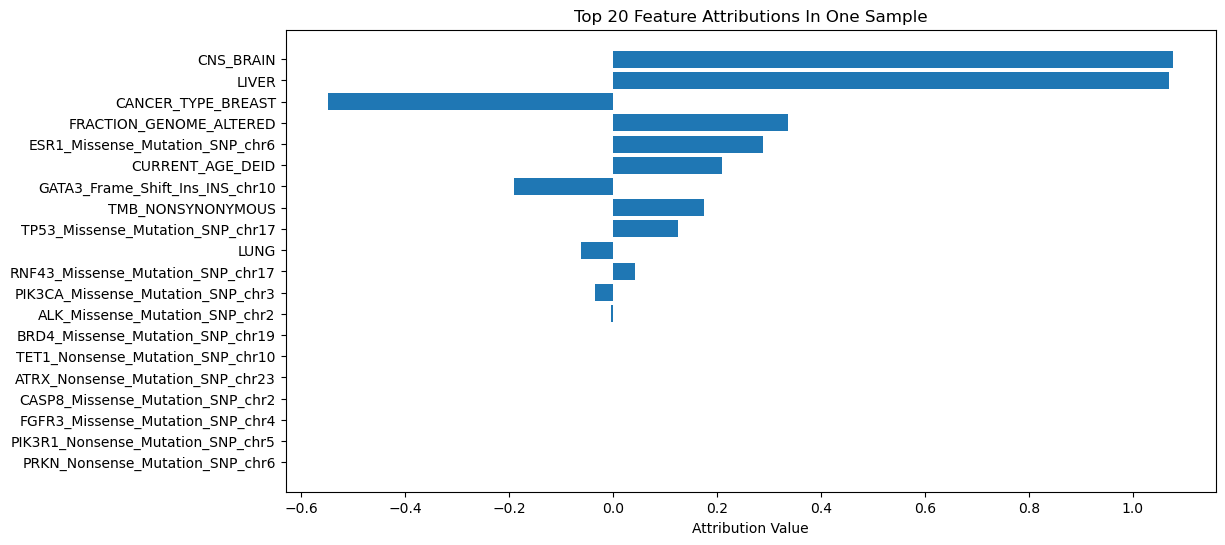

Convergence Delta: 0.029544891646693827


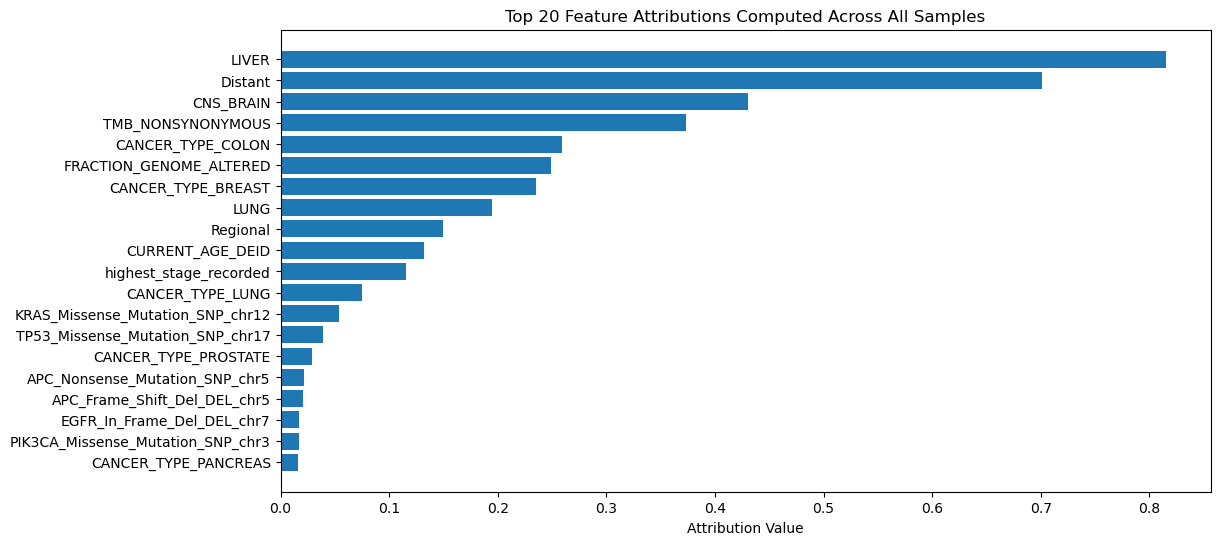

Convergence Delta: 0.029544891646693827


In [9]:
interpret_model(ae_model=model,
                ds_model=ds_model,
                ae_best_model=best_model,
                ds_best_model=ds_best_model,
                ae_type=ae_type,
                gmp_index=GMP.shape[1],
                all_columns=all_columns,
                X_test=fulldata_set,
                verbose=False,
                sample_size=1000,
                device=device)

/home/yliu802/miniconda3/envs/csci2470/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


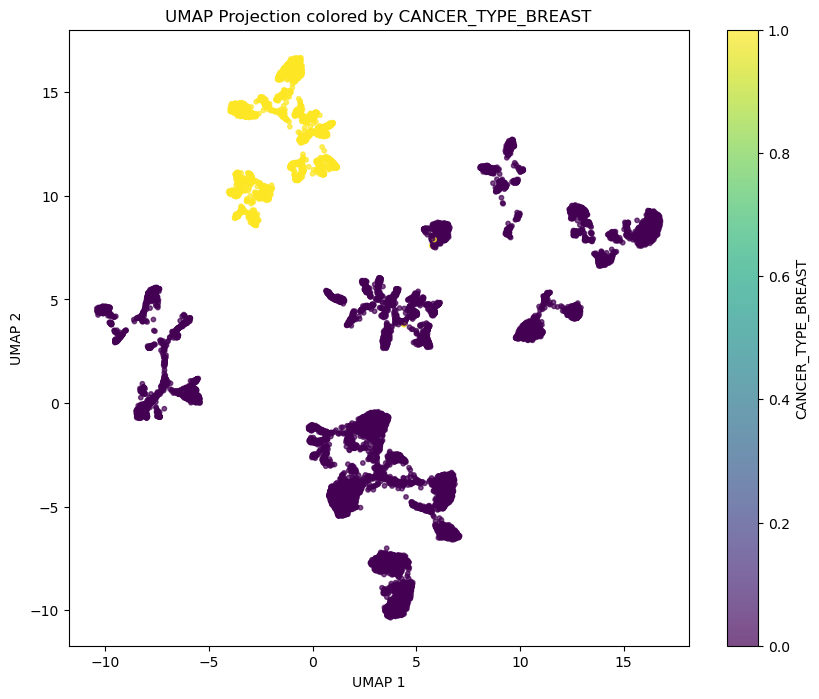

/home/yliu802/miniconda3/envs/csci2470/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


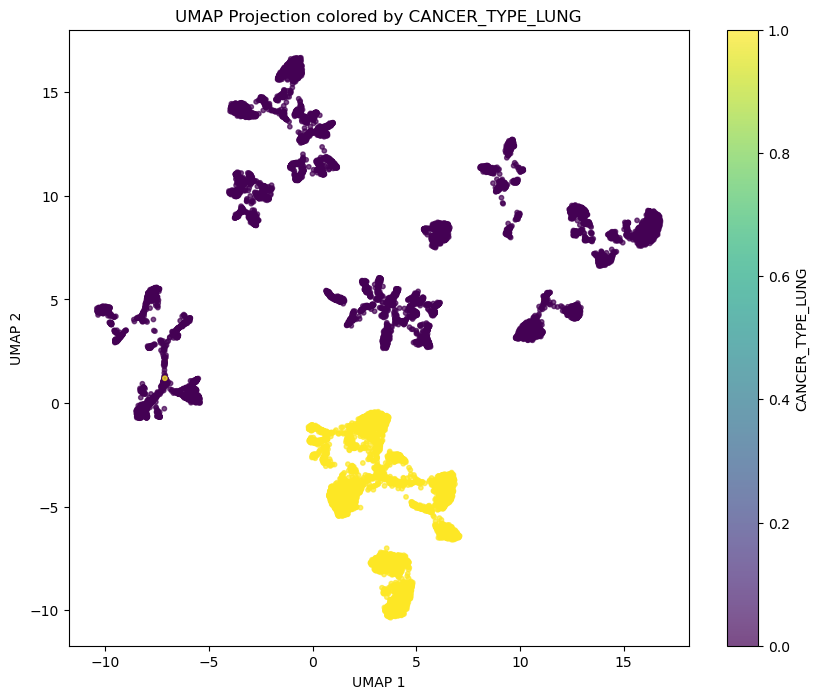

/home/yliu802/miniconda3/envs/csci2470/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


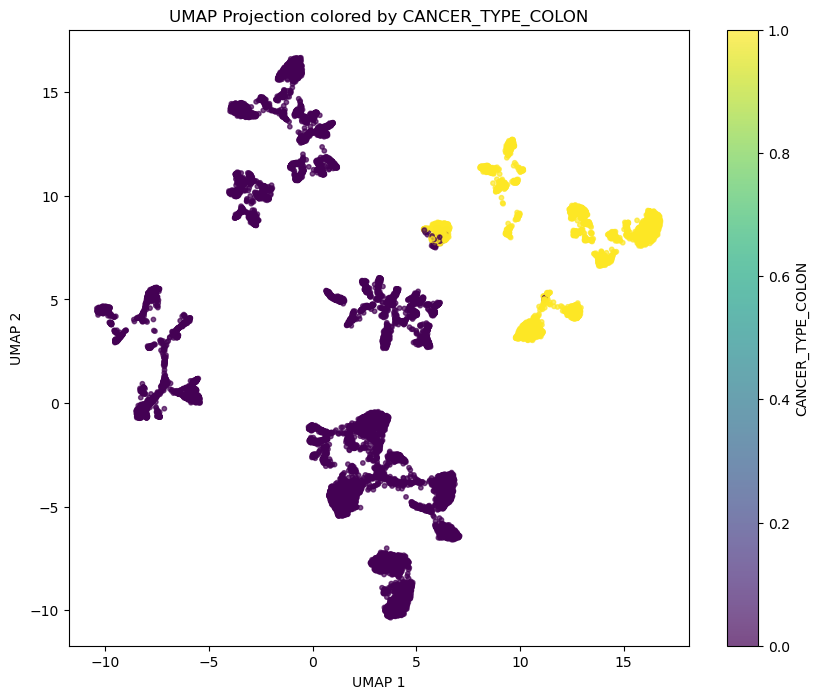

/home/yliu802/miniconda3/envs/csci2470/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


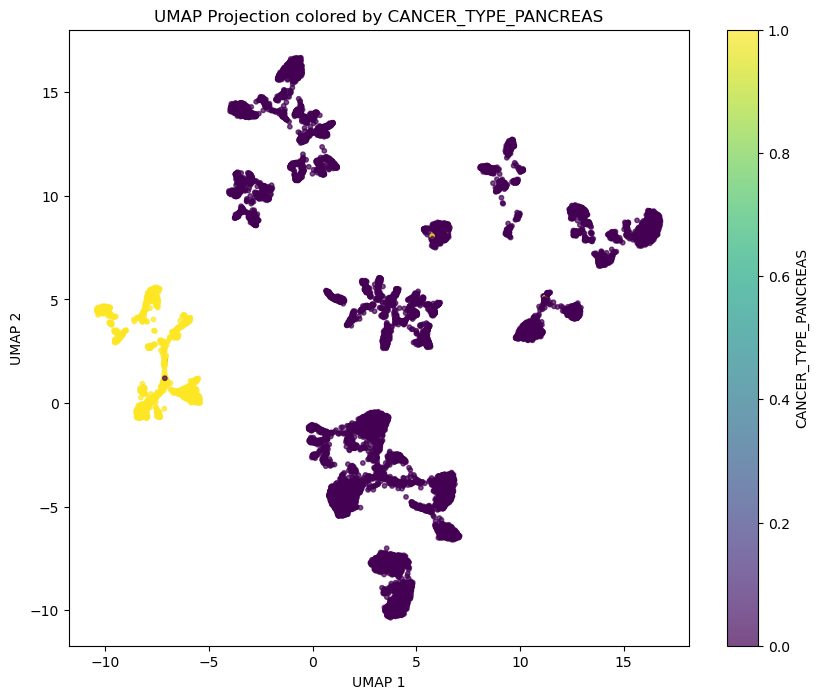

/home/yliu802/miniconda3/envs/csci2470/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


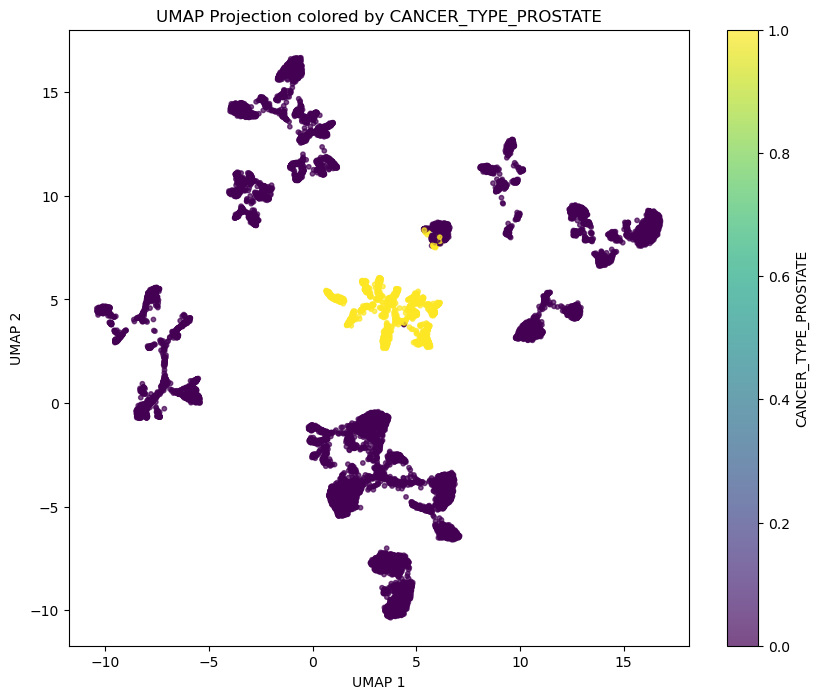

In [10]:
# targets = ['highest_stage_recorded','CNS_BRAIN','LIVER','LUNG','Regional','Distant','CANCER_TYPE_BREAST','CANCER_TYPE_LUNG','CANCER_TYPE_COLON','CANCER_TYPE_PANCREAS','CANCER_TYPE_PROSTATE']
targets = ['CANCER_TYPE_BREAST','CANCER_TYPE_LUNG','CANCER_TYPE_COLON','CANCER_TYPE_PANCREAS','CANCER_TYPE_PROSTATE']

# Get highest stage recorded; convert to float32 for PyTorch
y = df[targets].values.astype(np.float32)

plot_umap_by_targets(
    latent_rep,
    y,
    targets,
    save_path_prefix=None
)